# Tag Modeling

## Import packages

In [613]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd
#from gensim import corpora, models, similarities, matutils

## Mongo Connection

In [468]:
client = MongoClient(port=27017)
db = client.crypto
tags = db.tweets_tags

In [471]:
tags.find_one({"hashtags":"iheartawards"})

{'_id': ObjectId('5a9609c51b9d8f0a7da9b4b6'),
 'created_at': 'Wed Feb 28 01:45:41 +0000 2018',
 'hashtags': ['iheartawards', 'bestboyband', 'bts', 'hixtape_d2'],
 'symbols': [],
 'text': '6 love for my @BTS_twt #iHeartAwards #BestBoyBand #BTS\n\n#HIXTAPE_D2',
 'truncated': False,
 'tweet_id': 968663465328979968,
 'user_id': 919788170195038208,
 'user_name': 'Istri Sah Jin'}

## Tweets - Tags

### Load Data Sample

In [4]:
def preprocess_text(string):
    pass
    #re.compile()

In [5]:
sample_size = 200000
data = []

for x in tags.aggregate([{"$sample":{"size":sample_size}}], allowDiskUse = True):
    row = {}
    row["user"] = x["user_id"]
    row["tags"] = list(set(x["hashtags"] + x["symbols"]))
#    row["text_raw"] = x["text"]
#    row["text_clean"] = preprocess(x["text"])
    data.append(row)

df = pd.DataFrame(data)

df.head()
    

,tags,user
0,"[healthonblockchain, blockchain, trustedhealth]",97085375
1,"[iheartawards, bestboyband, bts]",892499334935191553
2,"[ltc, burst, ngc, fct, bts, bsd, club, nuls, s...",903166399593549824
3,"[pumpkinpay, blockchain, ico, cryptobountyprog...",1648807310
4,"[iheartawards, bestboyband, bts]",960793649859608577


### TFIDF

In [6]:
vectorizer = TfidfVectorizer(tokenizer = (lambda i:i),
                             lowercase=False,
                             max_df = 0.7,
                             min_df = 5
                            )
tfidf_vecs = vectorizer.fit_transform(df.tags)

In [7]:
print(tfidf_vecs.shape)
print(len(vectorizer.vocabulary_),len(vectorizer.stop_words_))

(200000, 5585)
5585 20642


### NMF

In [8]:
num_top_words = 15

nmf = NMF(n_components=10)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(np.reshape([(feature_names[i], topic[i])
                for i in topic.argsort()[:-n_top_words - 1:-1]], (-1//2,2)))

# def print_top_words(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print("Topic #%d:" % topic_idx)
#         print([(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]])        
        
print_top_words(nmf, vectorizer.get_feature_names(), num_top_words)

Topic #0:
[['bestboyband' '8.258270351610422']
 ['iheartawards' '8.180779246946756']
 ['bts' '7.943193977580659']
 ['thosfansbts4m' '0.26120819066450585']
 ['hopeworld' '0.2231865053205211']
 ['thosfansbts3m' '0.19369266384166114']
 ['bestfanarmy' '0.18424954219439776']
 ['btsarmy' '0.15601722316106414']
 ['jinday' '0.13272787547944515']
 ['thosfansbts1m' '0.11703415541258823']
 ['thosfansbts2m' '0.1043480891389902']
 ['thosfansbts28f' '0.09976560498659058']
 ['daydream' '0.08117320019317784']
 ['bts13m' '0.06159221504349682']
 ['hixtapeiscoming' '0.056122429096639975']]
Topic #1:
[['bitcoin' '12.999485195260176']
 ['news' '0.28802576390078977']
 ['ethereum' '0.1848347647604215']
 ['bitcoincash' '0.16919513126397792']
 ['litecoin' '0.1424507380845673']
 ['adk' '0.12495356757686911']
 ['aidoskuneen' '0.12493639607514637']
 ['cryptocurrencies' '0.11559696414444345']
 ['altcoins' '0.0936633939459045']
 ['altcoin' '0.08804633300476246']
 ['btcusd' '0.08483507539382489']
 ['trading' '0.0740

## Users - Tags

### Load Data Sample

In [721]:
print(tags.count())
print(tags.count({"hashtags":{"$ne":"iheartawards"}}))

927335
689175


In [722]:
sample_size = 900000
data = []

pipeline = [#{"$sample":{"size":sample_size}},
            {"$project": {"tweet_id":1, "user_id":1, "user_name":1, "tags":{"$concatArrays":["$hashtags","$symbols"]}}},
            {"$match": {"tags":{"$ne":"iheartawards"}}},
            {"$match": {"tags":{"$ne":"bestboyband"}}},
            {"$unwind":"$tags"}
           ]

for x in tags.aggregate(pipeline, allowDiskUse = True):
    row = {}
    row["tweet"]= x["tweet_id"]
    row["user"] = x["user_id"]
    row["user_name"] = x["user_name"]
    row["tag"] = x["tags"]
#    row["text_raw"] = x["text"]
#    row["text_clean"] = preprocess(x["text"])
    data.append(row)

df = pd.DataFrame(data)

del data

print(len(df))
df.head(10)

5564525


,tag,tweet,user,user_name
0,btc,968663454239350785,826395116483002368,someone somewhere
1,bitcoincash,968663454239350785,826395116483002368,someone somewhere
2,bitcoin,968663454239350785,826395116483002368,someone somewhere
3,ether,968663454239350785,826395116483002368,someone somewhere
4,ethereum,968663454239350785,826395116483002368,someone somewhere
5,crypto,968663454239350785,826395116483002368,someone somewhere
6,cryptocurrency,968663454239350785,826395116483002368,someone somewhere
7,solar,968663455510261760,892805453180174336,Jeff
8,michigan,968663455510261760,892805453180174336,Jeff
9,solarpower,968663455510261760,892805453180174336,Jeff


### User Stats

In [723]:
df_user_stats = df.groupby(by=["user"]).agg({"tag":["count","nunique"],
                                 "tweet":"nunique"})
df_user_stats.columns = ['_'.join(col).strip() for col in df_user_stats.columns.values]
df_user_stats["per_uniquetag"] = round(df_user_stats.tag_count / df_user_stats.tag_nunique,2)
df_user_stats["per_tweet"] = round(df_user_stats.tag_count / df_user_stats.tweet_nunique,2)

print ("Averages:\n tags {:.2f}, unique tags {:.2f}, unique tweets {:.2f}, per unique {:.2f}, per tweet {:.2f}" \
       .format(df_user_stats.tag_count.mean(), 
               df_user_stats.tag_nunique.mean(), 
               df_user_stats.tweet_nunique.mean(), 
               df_user_stats.per_uniquetag.mean(),
               df_user_stats.per_tweet.mean()))

print("\nTotal Users:",len(df_user_stats))

print("\nUsers with only x tweets:")
for i in range (1,10):
    print(i,np.sum(df_user_stats.tag_count<=i))

print("\n",df_user_stats.sort_values("tag_count",ascending=False).head(10))

print("\n",
      len(df_user_stats[df_user_stats.tag_nunique==1]),
      len(df_user_stats[(df_user_stats.tag_nunique==1)&(df_user_stats.tag_count>=25)])
     )
print(df_user_stats[df_user_stats.tag_nunique==1].sort_values("tweet_nunique",ascending=False).head(10))

Averages:
 tags 46.51, unique tags 10.43, unique tweets 5.69, per unique 3.00, per tweet 6.15

Total Users: 119642

Users with only x tweets:
1 8760
2 19927
3 28964
4 35370
5 43319
6 49965
7 54366
8 58467
9 72847

                     tag_count  tag_nunique  tweet_nunique  per_uniquetag  \
user                                                                       
629172295               56609          186           1653         304.35   
901112028663877632      56507          186           1654         303.80   
909009874498940928      28459          293           1089          97.13   
941606472298958848      23646           48           1383         492.62   
941607752518045697      23529           48           1257         490.19   
941224119835688960      22517           48           1240         469.10   
126255031               22119           22           1384        1005.41   
951025335876902912      15940           35            502         455.43   
947417939208232960      1

### Tags Stats

In [724]:
df_tag_stats = df.groupby(by=["tag"]).agg({"user":["count","nunique"],
                                 "tweet":"nunique"})
df_tag_stats.columns = ['_'.join(col).strip() for col in df_tag_stats.columns.values]
df_tag_stats["per_uniqueuser"] = round(df_tag_stats.user_count / df_tag_stats.user_nunique,2)
df_tag_stats["per_tweet"] = round(df_tag_stats.user_count / df_tag_stats.tweet_nunique,2)

print ("Averages:\n users {:.2f}, unique users {:.2f}, unique tweets {:.2f}, users per unique {:.2f}, users per tweet {:.2f}" \
       .format(df_tag_stats.user_count.mean(), 
               df_tag_stats.user_nunique.mean(), 
               df_tag_stats.tweet_nunique.mean(), 
               df_tag_stats.per_uniqueuser.mean(),
               df_tag_stats.per_tweet.mean()))

print("\nTotal Tags:",len(df_tag_stats))

print("\nTags with only x tweets:")
for i in range (1,10):
    print(i,np.sum(df_tag_stats.user_count<=i))
        
print("\n",df_tag_stats.sort_values("user_nunique",ascending=False).head(10))

df_tag_stats.head()

Averages:
 users 96.04, unique users 21.54, unique tweets 93.24, users per unique 2.47, users per tweet 1.01

Total Tags: 57940

Tags with only x tweets:
1 29876
2 37873
3 41680
4 43976
5 45637
6 46858
7 47811
8 48593
9 49229

                      user_count  user_nunique  tweet_nunique  per_uniqueuser  \
tag                                                                            
blockchain               170926         55374         168487            3.09   
cryptocurrency           167138         53536         164994            3.12   
bitcoin                  215307         52605         210111            4.09   
ico                      111870         43037         110191            2.60   
airdrop                   85187         41069          83096            2.07   
ethereum                  95410         37265          92863            2.56   
btc                      148873         31631         130104            4.71   
crypto                   131209         31080       

,user_count,user_nunique,tweet_nunique,per_uniqueuser,per_tweet
tag,,,,,
0100conferences,1,1,1,1.0,1.0
02marzo,3,2,3,1.5,1.0
0301wonhoday,9,3,9,3.0,1.0
03marzo,1,1,1,1.0,1.0
05x2617,1,1,1,1.0,1.0


### User - Tag Interactions

In [732]:
# Calculate users and tags with too few interactions to include
# Interaction is per tag per tweet per user...
# Tags can be used by one or many users in one or many tweets
# Users this can be one or many tags in one or many tweets
min_frequency = sample_size*.00001 #.001%

print("min frequency",min_frequency)

users_exclude = df_user_stats[df_user_stats.tag_count < min_frequency].reset_index().user
tags_exclude = df_tag_stats[df_tag_stats.user_count < min_frequency].reset_index().tag

print("excluding", len(users_exclude), "users", len(tags_exclude), "tags")

df_tag_stats_final = df_tag_stats.reset_index()
df_tag_stats_final = df_tag_stats_final[~df_tag_stats_final.tag.isin(tags_exclude)].reset_index(drop=True)

#df_tag_stats_final

#del df_tag_stats
#del df_user_stats

min frequency 9.0
excluding 58467 users 48593 tags


In [733]:
#'Tidy' User-Tag Interactions DF 
df_data = df[(~df.user.isin(users_exclude)) & (~df.tag.isin(tags_exclude))]

df_data = df_data.groupby(by=["user","tag"]).agg({"tag":["count"],"tweet":"nunique"})

df_data.columns = ['_'.join(col).strip() for col in df_data.columns.values]

df_data.reset_index(inplace=True)

print(len(df_data))

df_data.sort_values("tag_count",ascending=False).head()
#df[df.user==909009874498940928]
#"https://twitter.com/CoinSignalBot"


988777


,user,tag,tag_count,tweet_nunique
475158,909009874498940928,btc,8405,1088
66113,206789872,bitcoin,6284,6263
301255,3875339716,cybersecurity,6283,6269
301254,3875339716,bitcoin,6283,6269
66115,206789872,cybersecurity,6270,6250


### User - Tag Matrix

In [734]:
user_tag_df_full = df_data.pivot(index="user",columns="tag",values="tag_count")

user_tag_df_full.fillna(0,inplace=True)

print(user_tag_df_full.shape)

user_tag_df_full.head()

(61174, 9338)


tag,0301wonhoday,0655pm,0doubt,0ex,0ov,0ps,0x,100daysofcode,1080ti,10x,...,진,크립트레이드캐피탈,태태,태형,푸마,푸마대리구매,호비,호석,홉이,효정
user,,,,,,,,,,,,,,,,,,,,,
1585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [735]:
user_tag_df, user_tag_df_holdout = train_test_split(user_tag_df_full,test_size=.2,shuffle=True,random_state = 1)

del user_tag_df_full

print(len(user_tag_df),len(user_tag_df_holdout))

48939 12235


## Recommenders

### SVD

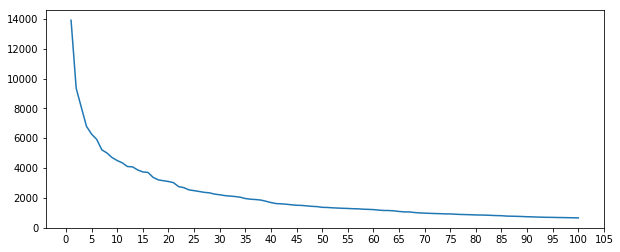

In [758]:
#adapted from:
#    kaggle.com/gspmoreira/recommender-systems-in-python-101
#    [...]/week07-fletcher/04-recommenders/simple_SVD_recommender.ipynb

user_tag_matrix = user_tag_df.as_matrix()
user_ids = list(user_tag_df.index)

U, Sigma_flat, VT = randomized_svd(user_tag_matrix, n_components=100)
Sigma = np.diag(Sigma_flat)


fig, ax = plt.subplots(figsize=(10,4))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.plot(range(1,len(Sigma_flat)+1),Sigma_flat)
plt.show()

In [759]:
U, Sigma_flat, VT = randomized_svd(user_tag_matrix, n_components=13)
Sigma = np.diag(Sigma_flat)

In [760]:
print (U.shape, Sigma.shape, VT.shape)

(48939, 13) (13, 13) (13, 9338)


### SVD Recommender

In [761]:
def cos_sim(a,b):
    '''Cosine similarity: (dot product)/(norm(a)*norm(b))'''
    dot = np.dot(a,b)
    return dot / (np.linalg.norm(a)*np.linalg.norm(b))

class SVD_Rec():
    def __init__ (self,U=None,Sigma=None,VT=None,df=None,similar_users=5, similar_items=10):
        self._U=U
        self._Sigma=Sigma
        self._VT=VT
        self._df=df
        self._similar_users = similar_users
        self._similar_items = similar_items

    def recommend_from_item(self, itemID, VSig=None, num_recom=None):
        if VSig is None:
            VSig = np.dot(self._VT.T,self._Sigma)
        if num_recom is None:
            num_recom = self._similar_items
        
        recs = []
        for item in range(VSig.shape[0]):
            if item != itemID:
                recs.append([item,cos_sim(VSig[itemID],VSig[item])])
        final_rec = [i[0] for i in sorted(recs,key=lambda x: x[1],reverse=True)]
        return final_rec[:num_recom]

        
    def make_item_array(self,tags_dict, df=None):
        if df is None:
            df=self._df
        row = pd.Series(0, index=df.columns)
        for k,v in tags_dict.items():
            if k in df.columns:
                row[k] = v
        return row

    def recommend_from_user_tags(self, tags_dict, U=None, Sigma=None, VT=None, df=None):
        if U is None:
            U=self._U
        if Sigma is None:
            Sigma=self._Sigma
        if VT is None:
            VT=self._VT
        if df is None:
            df=self._df
        user_df = self.make_item_array(tags_dict,df)
        user_vec = np.dot(user_df,VT.T)
        return self.recommend_from_user("new", np.dot(U,Sigma), df, user_vec, user_df,detail=False)

    
    def compile_recs(self,comp_users, df, input_user_row):
        
        recs = {}
        
        for comp_user in comp_users:            
            #Get items liked by the similar user, return those which the input user hasn't liked
            rec_likes = df.iloc[comp_user[0]]
            input_likes = input_user_row
            for i,item in enumerate(input_likes):
                if item == 0 and rec_likes[i]!=0:
                    if i in recs:
                        recs[i] = (recs[i][0]+rec_likes[i],recs[i][1])
                    else:
                        recs[i] = (rec_likes[i],rec_likes.index[i])
        return [(k,v[0],v[1]) for k,v in recs.items()]
    
    def recommend_from_user(self, userID, USig=None, df=None,user_vec=None,user_df_row=None,detail=True):
        if USig is None:
            USig=np.dot(self._U,self._Sigma)
        if df is None:
            df=self._df
        
        #Fill in user vec if not given
        if user_vec is None:
            user_vec = USig[userID]
        if user_df_row is None:
            user_df_row = df.iloc[userID]

        #Get SVD model users by similarity to user_vec
        userrecs = []
        for row in range(USig.shape[0]):
            userrecs.append([row, cos_sim(user_vec,USig[row])])
        final_rec = [i for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]
        #print(final_rec)

        # Skip matches that are ~exact (within float tolerance). 
        # Might be equal & we want some diversity
        i = 0 
        while (final_rec[i][1] >= 0.99999999):
            i+=1
        similar_user_list = final_rec[i:i+self._similar_users]
        if detail==True:
#            print("User %s's most similar user is User #%s, (%s) "% (userID, similar_user_list[0],similar_user_list[1]))
            print("User %s's most similar users are:"%userID, similar_user_list)
            
        recs = self.compile_recs(similar_user_list, df, user_df_row)
                
        #return sorted(recs,key=lambda x: x[1],reverse=True)                    
        return [x[2] for x in sorted(recs,key=lambda x: x[1],reverse=True)]
    


In [762]:
svd_recommender = SVD_Rec(U,Sigma,VT,user_tag_df)    

item_to_rec = 5
print("Items similar to item {}:".format(item_to_rec), svd_recommender.recommend_from_item(item_to_rec),"\n")

user_to_rec = 800
print("Items for User %s to check out: "% user_to_rec, svd_recommender.recommend_from_user(user_to_rec))

Items similar to item 5: [2318, 4684, 4900, 4753, 1092, 4982, 1087, 4, 2862, 4779] 



/home/perry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


User 800's most similar users are: [[14197, 0.9999999417839656], [21476, 0.9999999417839656], [11114, 0.9999999416514953], [25373, 0.9999999416514953], [26336, 0.9999894003849866]]
Items for User 800 to check out:  ['ivether', 'ivethertokens', 'bittrex', 'poloniex']


In [763]:
new_user_dict = {"btc":3}

print("New user with tags:",new_user_dict)
print("Items for new user to check out: ", svd_recommender.recommend_from_user_tags(new_user_dict))

#user_row = user_tag_df.iloc[1881]
#user_row[user_row>0].sort_values(ascending=False)

New user with tags: {'btc': 3}
Items for new user to check out:  ['es_f', 'ndx', 'spx', 'vix', 'amzn', 'btc.x', 'edit', 'theatre']


### Popularity Recommender

In [764]:
class Pop_Rec():
    
    def __init__ (self, tag_stats_df, similar_users=3, similar_items=10):
        self._current_sort = "user_nunique"
        self._df = tag_stats_df.sort_values(self._current_sort, ascending=False)
        self._similar_users = similar_users
        self._similar_items = similar_items
    
    def recommend(self, tags, sort_method = "user_nunique", n_recom = None):
        '''Sort_method should be one of the columns (user_count  user_nunique  tweet_nunique)'''
        if n_recom is None:
            n_recom = self._similar_items
        
        if self._current_sort != sort_method:
            self._df.sort_values(sort_method, ascending = False, inplace=True)
            self.current_sort = sort_method
        
        count = 0
        i = 0
        recs = []
        while count < n_recom:
            tag = self._df["tag"].iloc[i]
            item = self._df.index[i]
            if tag not in tags:
                #recs.append((item,tag))
                recs.append(tag)
                count += 1
                #print (tag, item, "\n", self._df.iloc[i])
            i += 1
        return recs


In [765]:
pop_recommender = Pop_Rec(df_tag_stats_final)
pop_recommender.recommend(["bts"])

['blockchain',
 'cryptocurrency',
 'bitcoin',
 'ico',
 'airdrop',
 'ethereum',
 'btc',
 'crypto',
 'pumpkinpay',
 'cryptobountyprogram']

## Test

### Score / Test

In [766]:
def row_score(new_user_df, pop_rec, svd_rec):
    name = new_user_df.name
    row = new_user_df.reset_index()
    row = row[row[name]>0].reset_index(drop=True)
    
    num_tags = len(row)
    if  num_tags == 1:
        return None
    
    tag_dict = {}
    test_index = random.randint(0,num_tags-1)
    test_tag = ""
    for i, val in row.iterrows():
        if i==test_index:
            test_tag = val[0]
            continue
        tag_dict[val[0]]=val[1]
    
    pop_10 = pop_rec.recommend(tag_dict.keys(),n_recom = 10)
    svd_10 = svd_rec.recommend_from_user_tags(tag_dict)
    
#     print(test_tag)
#     print(pop_10)
#     print(svd_10)
    
    return [test_tag in pop_10[:5],
            test_tag in pop_10[:],
            test_tag in svd_10[:5],
            test_tag in svd_10[:]]

def holdout_scores(holdout_df, pop_rec, svd_rec):
    scores = []
    total = 0
    for i, test_row in holdout_df.iterrows():
        score = row_score(test_row,pop_rec,svd_rec)
        if score is None:
            continue
        scores.append(score)
        total+=1
        if total % 1000 == 1:
            sum_scores = np.sum(scores,axis=0)
            print (total)
            print(sum_scores)
            print(sum_scores/total)
    
    sum_scores = np.sum(scores,axis=0)
    print("--Final--")
    print(sum_scores)
    print(total)
    print(sum_scores/total)
    

print(row_score(user_tag_df_holdout.iloc[0],pop_recommender,svd_recommender))

holdout_scores(user_tag_df_holdout,pop_recommender,svd_recommender)
    

[False, False, True, True]
1
[0 0 1 1]
[0. 0. 1. 1.]
1001
[503 592 482 663]
[0.5024975  0.59140859 0.48151848 0.66233766]
2001
[ 986 1154  975 1324]
[0.49275362 0.57671164 0.48725637 0.66166917]
3001
[1500 1740 1458 1986]
[0.49983339 0.57980673 0.48583805 0.66177941]
4001
[2020 2325 1957 2655]
[0.50487378 0.58110472 0.48912772 0.6635841 ]
5001
[2519 2899 2467 3326]
[0.50369926 0.57968406 0.49330134 0.66506699]
6001
[3042 3483 2986 4018]
[0.50691551 0.58040327 0.49758374 0.66955507]
7001
[3530 4044 3492 4680]
[0.50421368 0.57763177 0.49878589 0.66847593]
8001
[4024 4611 3966 5330]
[0.50293713 0.57630296 0.49568804 0.66616673]


/home/perry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


9001
[4496 5158 4467 6003]
[0.49950006 0.57304744 0.49627819 0.6669259 ]
10001
[4965 5710 4996 6688]
[0.49645035 0.57094291 0.49955004 0.66873313]
11001
[5461 6280 5490 7355]
[0.49640942 0.57085719 0.49904554 0.66857558]
12001
[5948 6848 5988 8030]
[0.49562536 0.57061912 0.49895842 0.66911091]
--Final--
[6011 6918 6057 8116]
12127
[0.49567082 0.5704626  0.49946401 0.66925043]


<Container object of 4 artists>

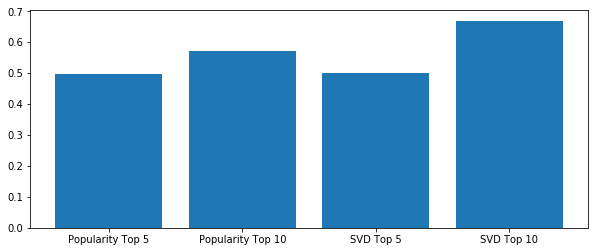

In [772]:
fig, ax = plt.subplots(figsize=(10,4))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(["","Popularity Top 5","Popularity Top 10","SVD Top 5","SVD Top 10"])
ax.bar([1,2,3,4],[0.49567082,0.5704626,0.49946401,0.66925043])